In [3]:
import rasterio
from rasterio.windows import from_bounds
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from rasterio.plot import show
from shapely.geometry import box, mapping
from pyproj import Transformer
import os
import numpy as np
import xarray as xr
from rasterio.windows import from_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.windows import bounds as window_bounds

In [4]:


# 📌 Step 1: Define your file paths
input_tif = "/mnt/datawaha/hyex/gahwagrw/SaudiUHI/sat_data/raw/Jeddah/landsat/LC08_L2SP_169046_20131224_02_T1_qa_pixel.tif"  # 🔁 Replace with actual path


# 📌 Step 2: Define your bounding box (xmin, ymin, xmax, ymax)
bbox_jd = (39.0053612,21.4210088,39.3253612,21.7410088)  # Jeddah
bbox_md = (39.4511216,24.311153,39.7711216,24.631153)
bbox_mk = (39.666869,21.260847,39.986869,21.580847)
bbox_tf =  (40.2558308,21.1102801,40.5758308,21.4302801)

def add_buffer(bbox, buffer_deg):
    minlon, minlat, maxlon, maxlat = bbox
    return (minlon - buffer_deg, minlat - buffer_deg, maxlon + buffer_deg, maxlat + buffer_deg)

bbox = add_buffer(bbox_jd, 0.5)


In [5]:
with rasterio.open(input_tif) as src:
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)
    print("Resolution:", src.res)
    print("NoData:", src.nodata)
    print("Data type:", src.dtypes[0])

CRS: EPSG:32637
Bounds: BoundingBox(left=517785.0, bottom=2120985.0, right=745215.0, top=2352915.0)
Resolution: (30.0, 30.0)
NoData: None
Data type: uint16


In [8]:
#reproject 
from pyproj import Transformer
import numpy as np

def project_bbox_to_target_bounds(bbox_wgs84, target_crs="EPSG:32637", resolution=1000):
    # Reproject WGS84 bbox to projected CRS
    transformer = Transformer.from_crs("EPSG:4326", target_crs, always_xy=True)
    xmin, ymin = transformer.transform(bbox_wgs84[0], bbox_wgs84[1])
    xmax, ymax = transformer.transform(bbox_wgs84[2], bbox_wgs84[3])

    # Snap bounds to resolution grid
    xmin = int(xmin // resolution) * resolution
    xmax = int(np.ceil(xmax / resolution)) * resolution
    ymin = int(ymin // resolution) * resolution
    ymax = int(np.ceil(ymax / resolution)) * resolution

    print("Projected bounds (snapped):", (xmin, ymin, xmax, ymax))
    print("Width (px):", (xmax - xmin) // resolution)
    print("Height (px):", (ymax - ymin) // resolution)

    return (xmin, ymin, xmax, ymax)

              
target_bounds = project_bbox_to_target_bounds(bbox)
target_bounds

Projected bounds (snapped): (448000, 2313000, 586000, 2460000)
Width (px): 138
Height (px): 147


(448000, 2313000, 586000, 2460000)

In [9]:
target_crs = "EPSG:32637"
resolution = 1000

with rasterio.open(input_tif) as src:
    dst_transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds, resolution=(resolution, resolution)
    )

    dst_data = np.full((height, width), np.nan, dtype=np.float32)
    
    reproject(
        source=rasterio.band(src, 1),
        destination=dst_data,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=dst_transform,
        dst_crs=target_crs,
        resampling=Resampling.bilinear,
        src_nodata=0,             # specify original nodata
        dst_nodata=np.nan         # convert to NaN
    )

    # Use raster bounds from dst_transform and width/height
    dst_left, dst_top = dst_transform * (0, 0)
    dst_right, dst_bottom = dst_transform * (width, height)
    
    # Intersect bounds
    crop_left = max(dst_left, target_bounds[0])
    crop_right = min(dst_right, target_bounds[2])
    crop_bottom = max(dst_bottom, target_bounds[1])
    crop_top = min(dst_top, target_bounds[3])
    
    # Check if valid intersection
    if crop_left >= crop_right or crop_bottom >= crop_top:
        print("No overlap between target and reprojected raster.")
    
    window = from_bounds(crop_left, crop_bottom, crop_right, crop_top, transform=dst_transform)
    window = window.round_offsets().round_shape()
    
    cropped = dst_data[
    int(window.row_off):int(window.row_off + window.height),
    int(window.col_off):int(window.col_off + window.width)
    ]

print("Min:", np.nanmin(dst_data))
print("Max:", np.nanmax(dst_data))
print("NaN count:", np.isnan(dst_data).sum())
cropped.shape

Min: 1.0
Max: 54572.637
NaN count: 232


/home/gahwagrw/.local/lib/python3.8/site-packages/rasterio/windows.py:731: RasterioDeprecationWarning: round_shape is deprecated and will be removed in Rasterio 2.0.0.
  warnings.warn(


(40, 68)

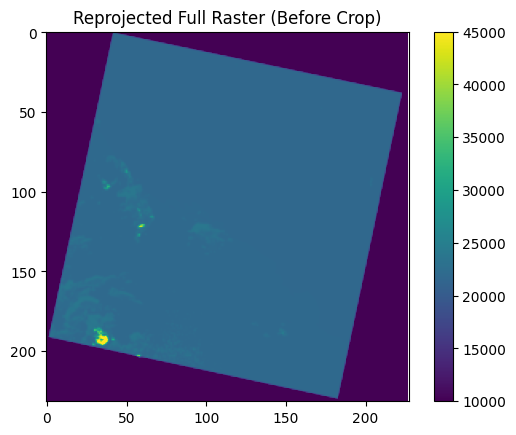

In [10]:

plt.imshow(dst_data, cmap="viridis", vmin=10000, vmax=45000)
plt.colorbar()
plt.title("Reprojected Full Raster (Before Crop)")
plt.show()


In [11]:
# crop to the desired 

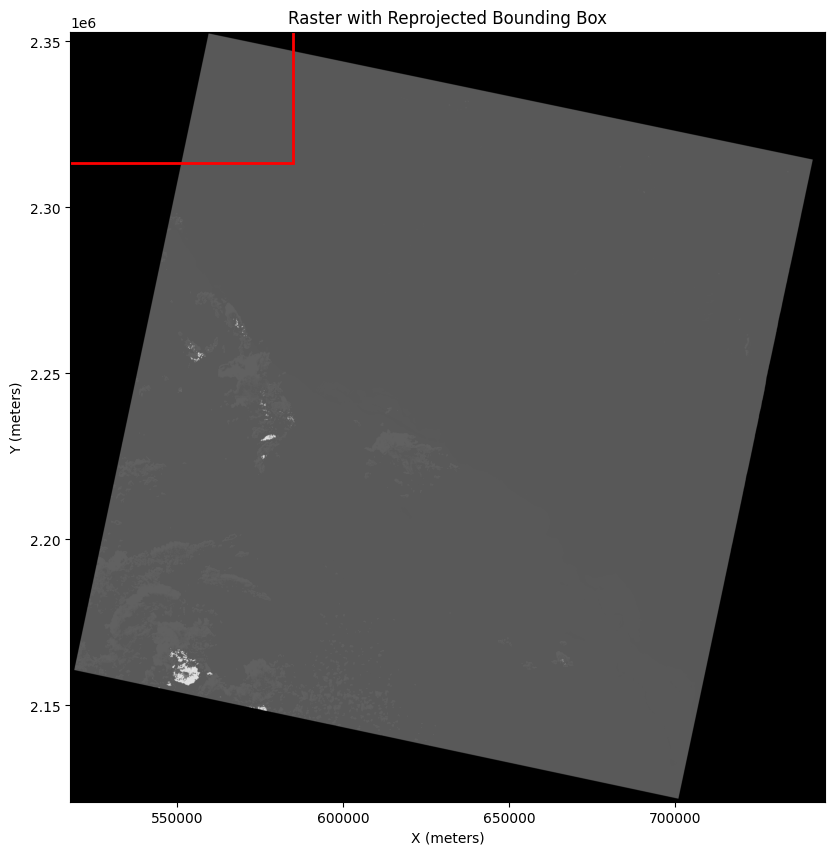

In [12]:
with rasterio.open(input_tif) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot raster
    show((src, 1), ax=ax, cmap='gray')
    
    # Reproject bbox to raster CRS
    transformer = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True)
    xmin, ymin = transformer.transform(bbox[0], bbox[1])
    xmax, ymax = transformer.transform(bbox[2], bbox[3])

    # Draw the bounding box in CRS coordinates
    rect = patches.Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(rect)

    ax.set_title("Raster with Reprojected Bounding Box")
    plt.xlabel("X (meters)")
    plt.ylabel("Y (meters)")
    plt.show()


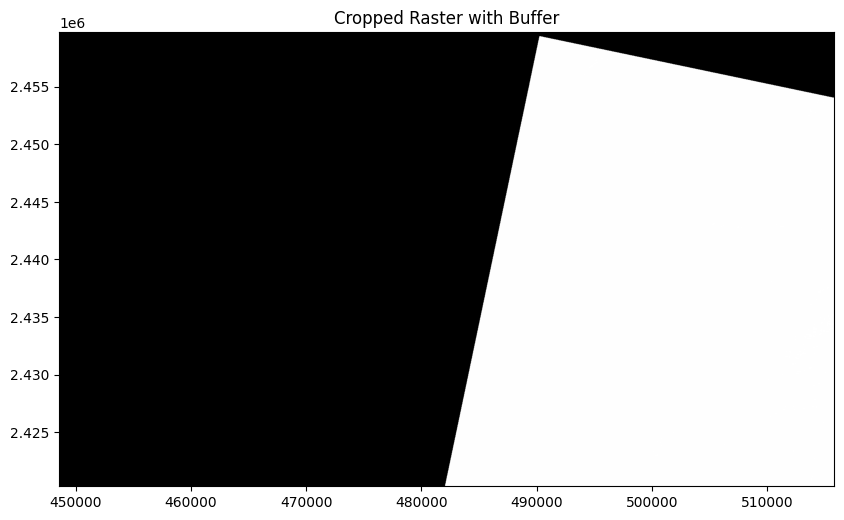

In [13]:
with rasterio.open(input_tif) as src:
    transformer = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True)
    xmin, ymin = transformer.transform(bbox[0], bbox[1])
    xmax, ymax = transformer.transform(bbox[2], bbox[3])

    # Get the window to read
    window = from_bounds(xmin, ymin, xmax, ymax, transform=src.transform)

    # Read the window
    data = src.read(1, window=window)  # Read first band, adjust as needed

    # Update transform for the window
    window_transform = src.window_transform(window)

    # Plot the cropped raster
    fig, ax = plt.subplots(figsize=(10, 10))
    show(data, transform=window_transform, ax=ax, cmap='gray')
    ax.set_title("Cropped Raster with Buffer")
    plt.show()

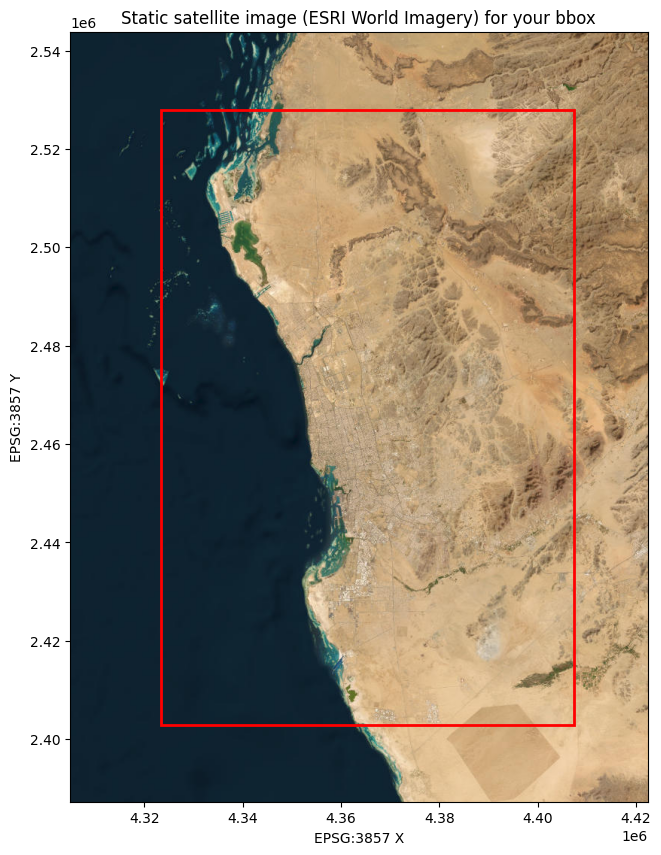

In [14]:
import contextily as ctx
import matplotlib.pyplot as plt
from pyproj import Transformer
import numpy as np

# Your bbox in WGS84 (lon_min, lat_min, lon_max, lat_max)
bbox_wgs84 = (38.837314, 21.092348, 39.592624, 22.136691)  # Jeddah example

# Convert bbox to Web Mercator (EPSG:3857) which tile servers use
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
xmin, ymin = transformer.transform(bbox_wgs84[0], bbox_wgs84[1])
xmax, ymax = transformer.transform(bbox_wgs84[2], bbox_wgs84[3])

# Define zoom level (0 = world, 18+ = street/building level)
zoom = 10  # adjust zoom for resolution/detail

# Fetch satellite image (ESRI World Imagery)
img, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, source=ctx.providers.Esri.WorldImagery)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img, extent=extent)
ax.set_title("Static satellite image (ESRI World Imagery) for your bbox")
ax.set_xlabel("EPSG:3857 X")
ax.set_ylabel("EPSG:3857 Y")
rect = patches.Rectangle(
    (xmin, ymin), xmax - xmin, ymax - ymin,
    linewidth=2, edgecolor='red', facecolor='none'
)
ax.add_patch(rect)
plt.show()


In [16]:
# 📌 Step 3: Open and crop the raster
with rasterio.open(input_tif) as src:
    window = from_bounds(*bbox, transform=src.transform)
    out_transform = src.window_transform(window)
    out_meta = src.meta.copy()

    out_meta.update({
        "height": window.height,
        "width": window.width,
        "transform": out_transform
    })

    data = src.read(window=window)

# 📌 Step 4: Save the cropped raster
with rasterio.open(output_tif, "w", **out_meta) as dst:
    dst.write(data)

print(f"✅ Cropped raster saved to {output_tif}")


NameError: name 'output_tif' is not defined

In [ ]:
# trying to stitch the data 

In [18]:
import os
import re
from collections import defaultdict

input_folder = "/mnt/datawaha/hyex/gahwagrw/SaudiUHI/sat_data/raw/Jeddah/landsat/"
pattern = r"^[^_]+_[^_]+_[^_]+_(\d{8})_.*_([a-zA-Z0-9_]+)\.tif$"

# Example: {'lwir11': {'20131224': [file1.tif, file2.tif]}}
grouped_files = defaultdict(lambda: defaultdict(list))

for fname in sorted(os.listdir(input_folder)):
    if not fname.lower().endswith('.tif'):
        continue
    match = re.match(pattern, fname)
    if match:
        date_str = match.group(1)
        band_name = match.group(2).lower()
        grouped_files[band_name][date_str].append(os.path.join(input_folder, fname))


In [19]:
from rasterio.merge import merge
import rasterio
import matplotlib.pyplot as plt

# Pick band/date
band = 'lwir11'
date = '20131224'
file_list = grouped_files[band][date]


In [20]:
# Open datasets
datasets = [rasterio.open(fp) for fp in file_list]

# Mosaic
mosaic, out_transform = merge(datasets, res=(1000, 1000), method='first')

# Close to avoid locks
for ds in datasets:
    ds.close()

# Show stats
print("Shape:", mosaic.shape)
print("Min:", mosaic.min())
print("Max:", mosaic.max())


Shape: (1, 392, 261)
Min: 0
Max: 49538


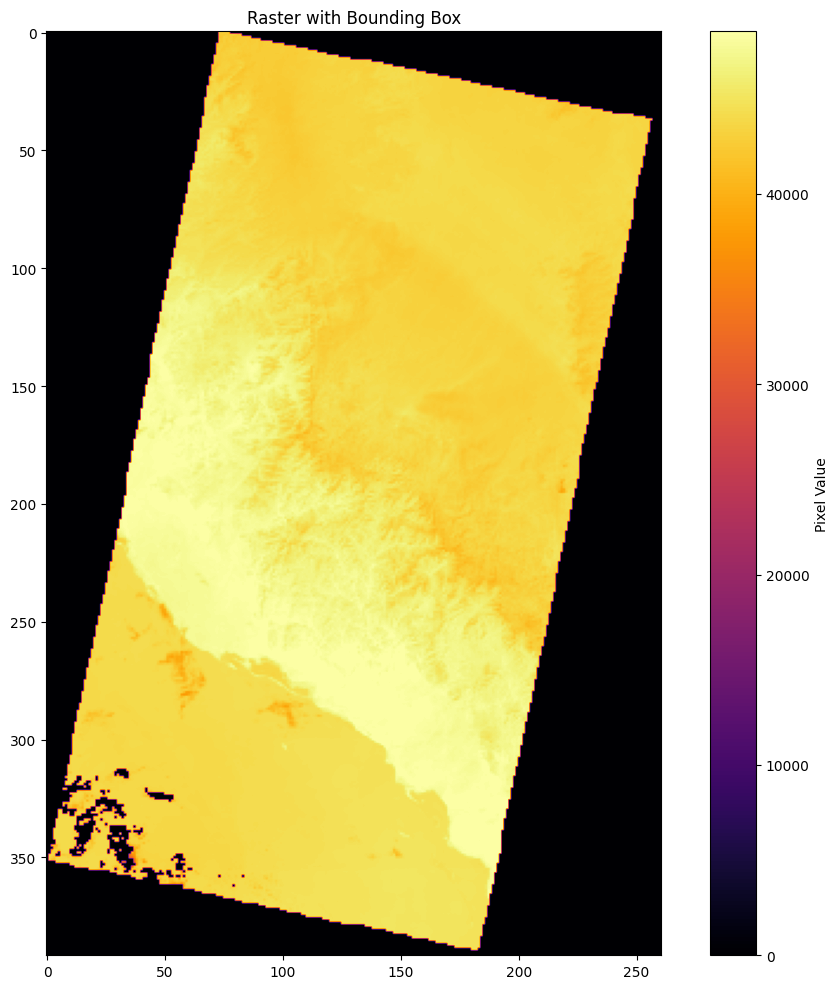

In [21]:
import matplotlib.pyplot as plt
from rasterio.plot import show
from pyproj import Transformer
import matplotlib.patches as patches

# Plot the raster
fig, ax = plt.subplots(figsize=(10, 10))
img = show(mosaic[0], ax=ax, cmap='inferno',
           vmin=np.nanpercentile(mosaic[0], 2),
           vmax=np.nanpercentile(mosaic[0], 98))

# Transform bbox from WGS84 to raster CRS (assume src.crs or EPSG:32637)
bbox = (39.0053612, 21.4210088, 39.3253612, 21.7410088)  # (minlon, minlat, maxlon, maxlat)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32637", always_xy=True)

xmin, ymin = transformer.transform(bbox[0], bbox[1])
xmax, ymax = transformer.transform(bbox[2], bbox[3])

# Draw bounding box
rect = patches.Rectangle(
    (xmin, ymin),
    xmax - xmin,
    ymax - ymin,
    linewidth=2,
    edgecolor='red',
    facecolor='none'
)
ax.add_patch(rect)

# Titles and legend
ax.set_title("Raster with Bounding Box")
plt.colorbar(img.get_images()[0], ax=ax, label="Pixel Value")
plt.tight_layout()
plt.show()

